### Summary
This code pre-processes all ice-front proximal OMG CTD's for input into a buoyant plume model.

Data Sources Used:
OMG CTD Data: Oceans Melting Greenland (OMG) Conductivity-Temperature-Depth profiles from both:

Regular CTD casts (OMG_L2_CTD_1-20250701_142048)
AXCTD (Airborne eXpendable CTD) deployments (OMG_AXCTD)

Extends all temperature, salinity, and density profiles to a uniform depth grid
Handles missing data through interpolation and smoothing
Creates a standardized xarray dataset with consistent dimensions
Plume Modeling:

Implements an ensemble approach using Latin Hypercube Sampling 
Runs a buoyant plume model with varying parameters:
Q0: Discharge rate (0.005-5 m³/s)
alpha: Entrainment coefficient (0.05-0.15, based on Slater et al. 2022; Kimura et al. 2014)
z_max: Maximum depth factor (0.6-1.4)
Uses the run_plume function to simulate plume dynamics for each CTD profile

In [ ]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle
import tempfile
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from pyDOE import lhs
import sys

from dask.distributed import Client, LocalCluster
from tqdm.notebook import tqdm
from dask import delayed, compute

Reading filtered OMG CTD file list CSV...
Total NetCDF files found: 366
Filtered NetCDF files: 94

Reading filtered OMG AXCTD file list CSV...
Total NetCDF files found: 1390
Filtered NetCDF files: 110

Starting Dask cluster...


c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54094 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:54095' processes=4 threads=8, memory=31.69 GiB>
Dask dashboard URL: http://127.0.0.1:54094/status

Total NetCDF files to process: 204

Opening datasets in parallel...


Reading NetCDFs:   0%|          | 0/204 [00:00<?, ?it/s]


Calculating max obs size and max depth...
Max obs size: 41060
Max depth: 1013.8663940429688
Min depth: -0.3404163420200348

Allocating extended dataset arrays...
Processing and interpolating profiles...


Processing profiles:   0%|          | 0/204 [00:00<?, ?it/s]


Creating xarray Dataset...

Interpolating and smoothing missing values...


Interpolating/smoothing:   0%|          | 0/204 [00:00<?, ?it/s]


Filtering unrealistic profiles...

Dropped 6 profiles with unrealistic values.

Closed Dask cluster.
Processing complete.

Plotting profiles...

Closed Dask cluster.
Processing complete.

Plotting profiles...


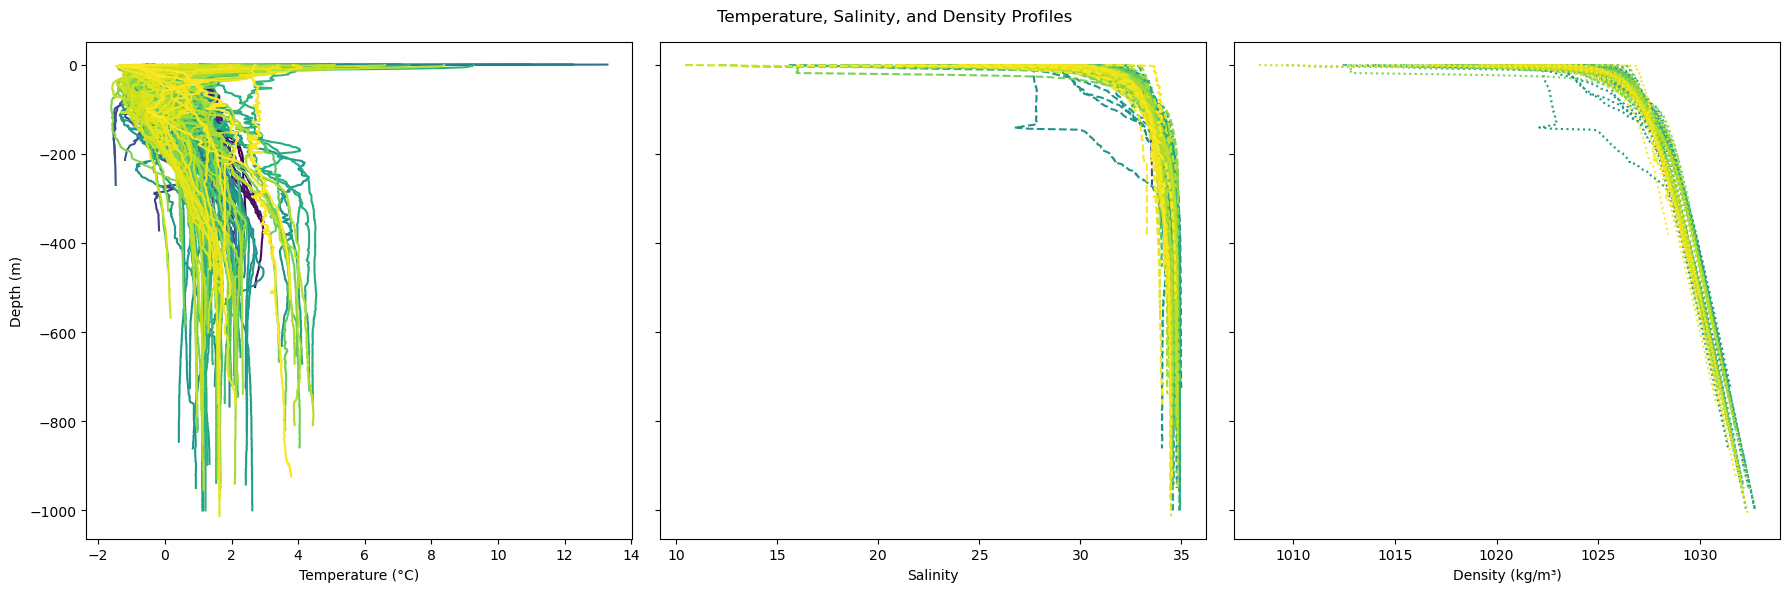


Saving combined dataset to NetCDF...


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\s1834371\\OneDrive - University of Edinburgh\\data\\CTD_data\\OMG_AXCTD\\OMG_AXCTD_CTD_combined_reduced.nc'

In [ ]:
# from shapefile extract "dates" property
def extract_dates_from_shapefile(shapefile_path):
    import geopandas as gpd
    gdf = gpd.read_file(shapefile_path)
    dates_list = gdf['date'].tolist()
    dates_int = [int(date.replace('-', '')) for date in dates_list]
    
    return dates_int

def process_and_visualize_profiles(
    directory, file_pattern='*.nc', max_depth=1000, rolling_window=1):
    """
    Processes and visualizes temperature and salinity profiles from NetCDF files

    Parameters:
    - directory: str, the directory containing the NetCDF files.
    - file_pattern: str, the pattern to match NetCDF files.
    - max_depth: int, the maximum depth to extend profiles.
    - rolling_window: int, the window size for smoothing the data.

    Returns:
    - extended_dataset: xarray.Dataset, the processed dataset.
    """
    ##### Getting OMG CTD file lists #####
    print("Reading filtered OMG CTD file list CSV...")
    shapefile_path = r'C:/Users/s1834371/OneDrive - University of Edinburgh/data/CTD_data/OMG_CTD/OMG_L2_CTD_1-20250701_142048/OMG_CTD_points.shp'
    dates_OMG_ctd = extract_dates_from_shapefile(shapefile_path)  

    directory = r'C:/Users/s1834371/OneDrive - University of Edinburgh/data/CTD_data/OMG_CTD/OMG_L2_CTD_1-20250701_142048'
    file_pattern = 'OMG_Ocean*.nc'
    netcdf_files_OMG_CTD = glob.glob(f'{directory}/{file_pattern}')      
    print('Total NetCDF files found:', len(netcdf_files_OMG_CTD))
    netcdf_files_OMG_CTD = [file for file in netcdf_files_OMG_CTD if any(str(date) in file for date in dates_OMG_ctd)]
    print('Filtered NetCDF files:', len(netcdf_files_OMG_CTD))

    ##### Getting OMG AXCTD file lists #####
    print("\nReading filtered OMG AXCTD file list CSV...")
    file_dir = r"G:\Other computers\My Laptop\ForGDRIVE\PLUME_work\PLUMES\fjords_gl_sill_depths_reduced.csv"
    fjords_gl_sill_depths = pd.read_csv(file_dir)

    fjord_columns = [col for col in fjords_gl_sill_depths.columns if col.startswith('fjord')]
    fjord_values = {col: fjords_gl_sill_depths[col].dropna().tolist() for col in fjord_columns}

    dates_OMG_AXCTD = []
    for col, values in fjord_values.items():
        dates_OMG_AXCTD.extend([int(value) for value in values if pd.notna(value)])
    dates_OMG_AXCTD = sorted(set(dates_OMG_AXCTD))

    directory = r'C:/Users/s1834371/OneDrive - University of Edinburgh/data/CTD_data/OMG_AXCTD'
    file_pattern = 'OMG_Ocean*.nc'
    netcdf_files_OMG_AXCTD = glob.glob(f'{directory}/{file_pattern}')
    print('Total NetCDF files found:', len(netcdf_files_OMG_AXCTD))

    netcdf_files_OMG_AXCTD = [file for file in netcdf_files_OMG_AXCTD if any(str(date) in file for date in dates_OMG_AXCTD)]
    print('Filtered NetCDF files:', len(netcdf_files_OMG_AXCTD))

    ### start dask cluster
    print("\nStarting Dask cluster...")
    cluster = LocalCluster()
    client = Client(cluster)
    print(client)

    # print dashboard URL
    print(f"Dask dashboard URL: {cluster.dashboard_link}")

    def open_and_extract(file):
        ds = xr.open_dataset(file)
        temp_profile = ds['temperature']
        sal_profile = ds['salinity']
        depth_profile = ds['depth']
        dens_profile = ds['density'] 
        date = ds['time'].values[0]
        lat = ds['lat'].values[0]
        lon = ds['lon'].values[0]
        return {
            'temperature': temp_profile,
            'salinity': sal_profile,
            'depth': depth_profile,
            'density': dens_profile,
            'date': date,
            'lat': lat,
            'lon': lon,
            'file': file
        }
    
    # combine datasets from both OMG CTD and OMG AXCTD
    netcdf_files_ALL = netcdf_files_OMG_CTD + netcdf_files_OMG_AXCTD
    print(f"\nTotal NetCDF files to process: {len(netcdf_files_ALL)}")

    print("\nOpening datasets in parallel...")
    datasets = [delayed(open_and_extract)(file) for file in netcdf_files_ALL] # using Dask's delayed
    datasets = list(tqdm(compute(*datasets), total=len(datasets), desc="Reading NetCDFs")) 

    print("\nCalculating max obs size and max depth...")
    max_obs_size = max(ds['temperature'].sizes['obs'] for ds in datasets)
    max_depth = max(ds['depth'].max().values for ds in datasets)
    min_depth = min(ds['depth'].min().values for ds in datasets)
    print('Max obs size:', max_obs_size)
    print('Max depth:', max_depth)
    print('Min depth:', min_depth)

    new_depth_coord = np.arange(0, max_depth, 1)
    n_profiles = len(datasets)

    print("\nAllocating extended dataset arrays...")
    temp_arr = np.full((n_profiles, len(new_depth_coord)), np.nan)
    sal_arr = np.full((n_profiles, len(new_depth_coord)), np.nan)
    depth_arr = np.full((n_profiles, len(new_depth_coord)), np.nan)
    dens_arr = np.full((n_profiles, len(new_depth_coord)), np.nan)
    date_arr = np.full(n_profiles, np.nan, dtype='datetime64[ns]')
    lat_arr = np.full(n_profiles, np.nan)
    lon_arr = np.full(n_profiles, np.nan)

    print("Processing and interpolating profiles...")
    for i, ds in enumerate(tqdm(datasets, desc="Processing profiles")):
        temp_profile = ds['temperature']
        sal_profile = ds['salinity']
        depth_profile = ds['depth']
        dens_profile = ds['density'] 
        date = ds['date']
        lat = ds['lat']
        lon = ds['lon']

        # subset ds to depths >= 0
        if depth_profile.min().values < 0:
            mask = depth_profile >= 0
            temp_profile = temp_profile.where(mask, drop=True)
            sal_profile = sal_profile.where(mask, drop=True)
            depth_profile = depth_profile.where(mask, drop=True)
            dens_profile = dens_profile.where(mask, drop=True)

        try:
            date_arr[i] = date
        except Exception as e:
            date_arr[i] = date[0]
            
        lat_arr[i] = lat
        lon_arr[i] = lon

        # Extend the depth to start from 0 if not already
        if depth_profile.min().values > 0:
            top_padding_length = int(depth_profile.min().values)
            if top_padding_length > 0:
                top_temp_padding = np.full(top_padding_length, temp_profile[0].values.item())
                top_sal_padding = np.full(top_padding_length, sal_profile[0].values.item())
                top_depth_padding = np.arange(0, depth_profile.min().values)
                top_dens_padding = np.full(top_padding_length, dens_profile[0].values.item())
                extended_temp_profile = np.concatenate([top_temp_padding, temp_profile.values.flatten()])
                extended_sal_profile = np.concatenate([top_sal_padding, sal_profile.values.flatten()])
                extended_depth_profile = np.concatenate([top_depth_padding, depth_profile.values.flatten()])
                extended_dens_profile = np.concatenate([top_dens_padding, dens_profile.values.flatten()])
            else:
                extended_temp_profile = temp_profile.values.flatten()
                extended_sal_profile = sal_profile.values.flatten()
                extended_depth_profile = depth_profile.values.flatten()
                extended_dens_profile = dens_profile.values.flatten()
        else:
            extended_temp_profile = temp_profile.values.flatten()
            extended_sal_profile = sal_profile.values.flatten()
            extended_depth_profile = depth_profile.values.flatten()
            extended_dens_profile = dens_profile.values.flatten()

        padding_length = int(max_depth - depth_profile.max().values)
        if padding_length >= 0:
            bottom_temp_padding = np.full(padding_length, np.nan)
            bottom_sal_padding = np.full(padding_length, np.nan)
            bottom_depth_padding = np.linspace(depth_profile.max().values, max_depth, num=padding_length, endpoint=False)
            bottom_dens_padding = np.full(padding_length, np.nan)
            extended_temp_profile = np.concatenate([extended_temp_profile, bottom_temp_padding])
            extended_sal_profile = np.concatenate([extended_sal_profile, bottom_sal_padding])
            extended_depth_profile = np.concatenate([extended_depth_profile, bottom_depth_padding])
            extended_dens_profile = np.concatenate([extended_dens_profile, bottom_dens_padding])


        if not (len(extended_depth_profile) == len(extended_temp_profile) == len(extended_sal_profile) == len(extended_dens_profile)):
            print(f"\bWarning: Profile {i} in file {ds['file']} has mismatched lengths after extension. Skipping.")
            print(f"Lengths - Depth: {len(extended_depth_profile)}, Temp: {len(extended_temp_profile)}, Sal: {len(extended_sal_profile)}, Dens: {len(extended_dens_profile)}")
            continue

        resampled_temp = np.interp(new_depth_coord, extended_depth_profile, extended_temp_profile, left=np.nan, right=np.nan)
        resampled_sal = np.interp(new_depth_coord, extended_depth_profile, extended_sal_profile, left=np.nan, right=np.nan)
        resampled_dens = np.interp(new_depth_coord, extended_depth_profile, extended_dens_profile, left=np.nan, right=np.nan)

        temp_arr[i, :] = resampled_temp
        sal_arr[i, :] = resampled_sal
        depth_arr[i, :] = new_depth_coord
        dens_arr[i, :] = resampled_dens

    print("\nCreating xarray Dataset...")
    extended_dataset = xr.Dataset(
        {
            'temperature': (('profile', 'obs'), temp_arr),
            'salinity': (('profile', 'obs'), sal_arr),
            'depth': (('profile', 'obs'), depth_arr),
            'density': (('profile', 'obs'), dens_arr)
        },
        coords={
            'profile': np.arange(n_profiles),
            'obs': np.arange(len(new_depth_coord)),
            'date': ('profile', date_arr),
            'latitude': ('profile', lat_arr),
            'longitude': ('profile', lon_arr)
        }
    )

    print("\nInterpolating and smoothing missing values...")
    for profile in tqdm(extended_dataset['temperature'].profile, desc="Interpolating/smoothing"):
        extended_dataset['temperature'].loc[dict(profile=profile)] = (
            extended_dataset['temperature'].sel(profile=profile).interpolate_na(dim='obs', method='linear')
            .rolling(obs=rolling_window, center=True).mean()
        )
        extended_dataset['salinity'].loc[dict(profile=profile)] = (
            extended_dataset['salinity'].sel(profile=profile).interpolate_na(dim='obs', method='linear')
            .rolling(obs=rolling_window, center=True).mean()
        )
        extended_dataset['depth'].loc[dict(profile=profile)] = (
            extended_dataset['depth'].sel(profile=profile).interpolate_na(dim='obs', method='linear')
        )

        extended_dataset['density'].loc[dict(profile=profile)] = (
            extended_dataset['density'].sel(profile=profile).interpolate_na(dim='obs', method='linear')
            .rolling(obs=rolling_window, center=True).mean()
        )

    print("\nFiltering unrealistic profiles...")
    to_drop = []
    for profile in extended_dataset.profile:
        if (
            extended_dataset['temperature'].sel(profile=profile).max() > 20 or
            extended_dataset['salinity'].sel(profile=profile).min() < 10
        ):
            to_drop.append(profile)
    if to_drop:
        extended_dataset = extended_dataset.drop_sel(profile=to_drop)
        print(f"\nDropped {len(to_drop)} profiles with unrealistic values.")

    client.close()
    cluster.close()
    print("\nClosed Dask cluster.")

    print("Processing complete.")
    return extended_dataset

combined_omg_ctd_ds = process_and_visualize_profiles(
    'C:/Users/s1834371/OneDrive - University of Edinburgh/data/CTD_data/OMG_AXCTD',
    file_pattern='OMG_Ocean*.nc'
)

print("\nPlotting profiles...")
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

num_profiles = len(combined_omg_ctd_ds.profile)
colors = plt.cm.viridis(np.linspace(0, 1, num_profiles))

for idx, profile in enumerate(combined_omg_ctd_ds.profile):
    color = colors[idx]
    axs[0].plot(
        combined_omg_ctd_ds['temperature'].sel(profile=profile),
        combined_omg_ctd_ds['depth'].sel(profile=profile) * -1,
        color=color,
        label=f'Profile {profile.values}'
    )
    axs[1].plot(
        combined_omg_ctd_ds['salinity'].sel(profile=profile),
        combined_omg_ctd_ds['depth'].sel(profile=profile) * -1,
        color=color,
        linestyle='--'
    )
    axs[2].plot(
        combined_omg_ctd_ds['density'].sel(profile=profile),
        combined_omg_ctd_ds['depth'].sel(profile=profile) * -1,
        color=color,
        linestyle=':'
    )

for ax, xlabel in zip(
    axs,
    ['Temperature (°C)', 'Salinity', 'Density (kg/m³)']
):
    ax.set_xlabel(xlabel)
axs[0].set_ylabel('Depth (m)')
plt.suptitle('Temperature, Salinity, and Density Profiles')
plt.tight_layout()
plt.show()

print("\nSaving combined dataset to NetCDF...")
combined_omg_ctd_ds.to_netcdf(
    'C:/Users/s1834371/OneDrive - University of Edinburgh/data/CTD_data/OMG_AXCTD/OMG_AXCTD_CTD_combined_reduced.nc'
)
print("\nDone.")


# Load in all OMG CTD files and do some more filerting

In [2]:
# load the dataset from the NetCDF file
combined_omg_ctd_ds = xr.open_dataset('C:/Users/s1834371/OneDrive - University of Edinburgh/data/CTD_data/OMG_AXCTD/OMG_AXCTD_CTD_combined_reduced.nc')

In [3]:
combined_omg_ctd_ds

# print year range
start_year = combined_omg_ctd_ds['date'].min(skipna=True)#.dt.year.item()
end_year = combined_omg_ctd_ds['date'].max(skipna=True)#.dt.year.item()
print(f"Year range: {start_year} - {end_year}")

Year range: <xarray.DataArray 'date' ()> Size: 8B
array('2015-07-25T22:08:36.920000000', dtype='datetime64[ns]') - <xarray.DataArray 'date' ()> Size: 8B
array('2021-09-16T12:18:13.000000000', dtype='datetime64[ns]')


In [ ]:
combined_omg_ctd_ds

<xarray.Dataset> Size: 6MB
Dimensions:      (profile: 198, obs: 1014)
Coordinates:
  * profile      (profile) int64 2kB 0 1 2 3 4 5 6 ... 198 199 200 201 202 203
  * obs          (obs) int64 8kB 0 1 2 3 4 5 6 ... 1008 1009 1010 1011 1012 1013
    date         (profile) datetime64[ns] 2kB 2015-07-25T22:08:36.920000 ... ...
    latitude     (profile) float64 2kB 69.81 69.79 69.81 ... 66.36 65.53 64.33
    longitude    (profile) float64 2kB -50.45 -50.34 -50.37 ... -39.91 -49.7
Data variables:
    temperature  (profile, obs) float64 2MB ...
    salinity     (profile, obs) float64 2MB ...
    depth        (profile, obs) float64 2MB ...
    density      (profile, obs) float64 2MB ...

In [ ]:
# get the first lat and lon values and save to one shapefile using geopandas
import geopandas as gpd
# get first lat/lon and date from each profile and save to a GeoDataFrame and shapefile

lats = []
lons = []
dates = []
for profile in combined_omg_ctd_ds.profile:
    lat = combined_omg_ctd_ds['latitude'].sel(profile=profile).values.item()
    lon = combined_omg_ctd_ds['longitude'].sel(profile=profile).values.item()
    date = combined_omg_ctd_ds['date'].sel(profile=profile).values.item()
    lats.append(lat)
    lons.append(lon)
    dates.append(date)

gdf = gpd.GeoDataFrame({
    'geometry': gpd.points_from_xy(lons, lats),
    'date': dates
})
gdf['date'] = pd.to_datetime(gdf['date'], format='%Y%m%d%H%M%S', errors='coerce')
# set the coordinate reference system to WGS84
gdf.set_crs(epsg=4326, inplace=True)
# save to shapefile
shapefile_path = 'OMG_AXCTD_CTD_combined_reduced.shp'
gdf.to_file(shapefile_path, driver='ESRI Shapefile')
    
    

c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field date create as date field, though DateTime requested.
  ogr_write(


# Run plume model simulations
Main plume model ensemble code block. Runs plume model in ensemble for all pre-processed OMG AXCTDs

In [7]:
import numpy as np
import xarray as xr
from tqdm import tqdm
from dask.distributed import Client, LocalCluster, as_completed as dask_as_completed
import sys
import pandas as pd
import logging

# Configure logging
logging.basicConfig(level=logging.DEBUG, filename='plume_simulation.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')

sys.path.append('G:/Other computers/My Laptop/ForGDRIVE/PLUME_work/PLUMES/plume_line_model')
from run_plume import run_plume

import numpy as np
import math

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx == 0:
        return 0
    elif idx == len(array):
        return idx - 1
    else:
        prev_idx = idx - 1
        if math.fabs(value - array[prev_idx]) <= math.fabs(value - array[idx]):
            return prev_idx
        else:
            return idx

def create_xarray_dataset(results):
    if not results:
        logging.error("No results available to create dataset.")
    max_depth = max(len(r['depth_profile']) for r in results if r is not None)

    temperature_profiles = np.full((len(results), max_depth), np.nan)
    depth_profiles = np.full((len(results), max_depth), np.nan)
    ctd_temp_profiles = np.full((len(results), max_depth), np.nan)
    ctd_density_profiles = np.full((len(results), max_depth), np.nan)
    ctd_salinity_profiles = np.full((len(results), max_depth), np.nan)

    Q0_values = []
    alpha_values = []
    z_max_values = []
    lat_values = []
    lon_values = []

    for idx, r in enumerate(results):
        if r is not None:
            profile_len = len(r['depth_profile'])
            temperature_profiles[idx, :profile_len] = r['temperature_profile']
            depth_profiles[idx, :profile_len] = r['depth_profile']
            ctd_temp_profiles[idx, :profile_len] = r['ctd_temp_profile']
            ctd_density_profiles[idx, :profile_len] = r['ctd_density_profile']
            ctd_salinity_profiles[idx, :profile_len] = r['ctd_salinity_profile']
            Q0_values.append(r['model_params']['Q0'])
            alpha_values.append(r['model_params']['alpha'])
            z_max_values.append(r['model_params']['z_max'])
            lat_values.append(r['latitude'])
            lon_values.append(r['longitude'])

    ds = xr.Dataset({
        'temperature_profile': xr.DataArray(temperature_profiles, dims=["profile", "depth"]),
        'depth_profile': xr.DataArray(depth_profiles, dims=["profile", "depth"]),
        'ctd_temp_profile': xr.DataArray(ctd_temp_profiles, dims=["profile", "depth"]),
        'ctd_density_profile': xr.DataArray(ctd_density_profiles, dims=["profile", "depth"]),
        'ctd_salinity_profile': xr.DataArray(ctd_salinity_profiles, dims=["profile", "depth"]),
        'Q0': xr.DataArray(Q0_values, dims=["profile"]),
        'alpha': xr.DataArray(alpha_values, dims=["profile"]),
        'z_max': xr.DataArray(z_max_values, dims=["profile"]),
        'latitude': xr.DataArray(lat_values, dims=["profile"]),
        'longitude': xr.DataArray(lon_values, dims=["profile"]),
    })

    return ds

def save_to_netcdf(ds, filename='plume_model_results.nc'):
    ds.to_netcdf(filename)
    logging.info(f"Data saved to {filename}")

def run_plume_profile(profile_idx, depth, temperature, salinity, density, Q0, alpha, z_max, Na, lat=None, lon=None):
    depth_sub = depth[depth >= z_max]
    if len(depth_sub) == 0:
        logging.debug(f"No sufficient depth at profile {profile_idx}")
        return None
    temperature_sub = temperature[:len(depth_sub)]
    salinity_sub = salinity[:len(depth_sub)]
    density_sub = density[:len(depth_sub)]

    try:
        solution = run_plume(depth_sub, np.full(depth_sub.shape, 0), temperature_sub, salinity_sub, np.full(depth_sub.shape, Na), Q0, alpha, stop_on_zero_velocity=True)
    except Exception as e:
        logging.error(f"Error running plume model for profile {profile_idx}, Q0={Q0}, alpha={alpha}, z_max={z_max}: {e}")
        return None
    if solution is None:
        logging.debug(f"No solution returned for profile {profile_idx}")
        return None
    return {
        'profile_id': profile_idx,
        'Q0': Q0,
        'alpha': alpha,
        'z_max': z_max,
        'temperature_profile': solution['T'],
        'depth_profile': solution['z'],
        'ctd_temp_profile': solution['Ta'],
        'ctd_density_profile': solution['rhoa'],
        'ctd_salinity_profile': solution['Sa'],
        'model_params' : {'Q0': Q0, 'alpha': alpha, 'z_max': z_max},
        'latitude' : lat,
        'longitude' : lon
    }


def run_plume_with_ctd_profiles(ctd_data, num_samples=30):
    Na = 1
    results = []
    Q0_range, alpha_range, z_max_range = (0.005, 5), (0.05, 0.15), (0.6, 1.4) # alpah range from Slater et al. 2022; Kimura et al. 2014

    lhs_samples = lhs(3, samples=num_samples)
    Q0_values = lhs_samples[:, 0] * (Q0_range[1] - Q0_range[0]) + Q0_range[0]
    alpha_values = lhs_samples[:, 1] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    z_max_values = lhs_samples[:, 2] * (z_max_range[1] - z_max_range[0]) + z_max_range[0]
    sample_params = np.column_stack((Q0_values, alpha_values, z_max_values))

    cluster = LocalCluster()
    client = Client(cluster)
    # Print dashboard URL
    print(f"Dask dashboard is available at: {client.dashboard_link}")

    tasks = []
    progress_file = 'progress.txt'
    for profile_idx in range(ctd_data.dims['profile']):
        depth = ctd_data['depth'].isel(profile=profile_idx).values * -1
        temperature = ctd_data['temperature'].isel(profile=profile_idx).values
        salinity = ctd_data['salinity'].isel(profile=profile_idx).values
        density = ctd_data['density'].isel(profile=profile_idx).values

        lat = ctd_data['latitude'].isel(profile=profile_idx).values
        lon = ctd_data['longitude'].isel(profile=profile_idx).values

        valid_idx = ~np.isnan(depth) & ~np.isnan(temperature) & ~np.isnan(salinity) & ~np.isnan(density)
        depth = depth[valid_idx]
        temperature = temperature[valid_idx]
        salinity = salinity[valid_idx]
        density = density[valid_idx]

        valid_idx = (temperature != 0.0) & (salinity != 0.0)
        depth = depth[valid_idx]
        temperature = temperature[valid_idx]
        salinity = salinity[valid_idx]
        density = density[valid_idx]

        for params in sample_params:
            Q0, alpha, z_max_param = params

            depth_copy = depth.copy()
            temperature_copy = temperature.copy()
            salinity_copy = salinity.copy()
            density_copy = density.copy()

            if depth_copy.size == 0:
                logging.debug(f"Skipped profile {profile_idx} due to invalid data. Depth size: {depth_copy.size}")
                continue

            max_depth = depth_copy.min()
            depth_spacing = np.diff(depth_copy).mean()
            z_max = np.round(max_depth * z_max_param)

            logging.info(f"Profile {profile_idx}: max_depth={max_depth}, z_max={z_max}")

            if z_max_param > 1.0:
                num_additional_points = abs(int((z_max - max_depth) / depth_spacing))
                additional_depths = np.arange(max_depth + depth_spacing, z_max + depth_spacing, depth_spacing)
                depth_copy = np.append(depth_copy, additional_depths)
                temperature_copy = np.concatenate([temperature_copy, np.full(len(additional_depths), temperature_copy[-1])])
                salinity_copy = np.concatenate([salinity_copy, np.full(len(additional_depths), salinity_copy[-1])])
                density_copy = np.concatenate([density_copy, np.full(len(additional_depths), density_copy[-1])])
            elif z_max_param < 1.0:
                depth_index = np.where(depth_copy <= z_max)[0][-1] + 1
                depth_copy = depth_copy[:depth_index]
                temperature_copy = temperature_copy[:depth_index]
                salinity_copy = salinity_copy[:depth_index]
                density_copy = density_copy[:depth_index]

            if len(depth_copy) != len(temperature_copy) or len(depth_copy) != len(salinity_copy) or len(depth_copy) != len(density_copy):
                if abs(len(depth_copy) - len(temperature_copy)) < 2:
                    logging.debug(f"Interpolating profile {profile_idx} due to mismatched lengths.")
                    if len(depth_copy) > len(temperature_copy):
                        num_additional_points = len(depth_copy) - len(temperature_copy)
                        temperature_copy = np.concatenate([temperature_copy, np.full(num_additional_points, temperature_copy[-1])])
                    else:
                        temperature_copy = temperature_copy[:len(depth_copy)]
                    if len(depth_copy) > len(salinity_copy):
                        num_additional_points = len(depth_copy) - len(salinity_copy)
                        salinity_copy = np.concatenate([salinity_copy, np.full(num_additional_points, salinity_copy[-1])])
                    else:
                        salinity_copy = salinity_copy[:len(depth_copy)]
                    if len(depth_copy) > len(density_copy):
                        num_additional_points = len(depth_copy) - len(density_copy)
                        density_copy = np.concatenate([density_copy, np.full(num_additional_points, density_copy[-1])])
                    else:
                        density_copy = density_copy[:len(depth_copy)]
                else:
                    logging.debug(f"Skipped profile {profile_idx} due to mismatched lengths.")
                    continue

            valid_idx = ~np.isnan(depth_copy) & ~np.isnan(temperature_copy) & ~np.isnan(salinity_copy) & ~np.isnan(density_copy)
            depth_copy = depth_copy[valid_idx]
            temperature_copy = temperature_copy[valid_idx]
            salinity_copy = salinity_copy[valid_idx]
            density_copy = density_copy[valid_idx]

            if depth_copy.size == 0 or depth_copy.size < 10:
                logging.debug(f"Skipped profile {profile_idx} due to invalid data.")
                continue

            future = client.submit(run_plume_profile, profile_idx, depth_copy, temperature_copy, salinity_copy, density_copy, Q0, alpha, z_max, Na, lat, lon)
            tasks.append(future)

        with open(progress_file, 'a') as file:
            file.write(f'{profile_idx}\n')

    with tqdm(total=len(tasks), desc="Running plume model (Dask)") as pbar:
        for future, result in dask_as_completed(tasks, with_results=True):
            if result is not None:
                results.append(result)
            pbar.update(1)

    client.close()
    cluster.close()
    return results

results = run_plume_with_ctd_profiles(combined_omg_ctd_ds, num_samples=40)
results_ds = create_xarray_dataset(results)
save_to_netcdf(results_ds, 'OMG_plume_ensemble_results_reduced_v3.nc')

c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60412 instead
  warnings.warn(


Dask dashboard is available at: http://127.0.0.1:60412/status


C:\Users\s1834371\AppData\Local\Temp\ipykernel_21532\120500784.py:133: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for profile_idx in range(ctd_data.dims['profile']):
2025-08-11 10:54:44,279 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p4710'}, 'attr': 'inner_width', 'new': 1501}, {'kind': 'ModelChanged', 'model': {'id': 'p4710'}, 'attr': 'inner_height', 'new': 517}, {'kind': 'ModelChanged', 'model': {'id': 'p4710'}, 'attr': 'outer_width', 'new': 1521}, {'kind': 'ModelChanged', 'model': {'id': 'p4710'}, 'attr': 'outer_height', 'new': 597}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\L

In [ ]:
results_ds

<xarray.Dataset> Size: 170MB
Dimensions:               (profile: 4240, depth: 1000)
Dimensions without coordinates: profile, depth
Data variables:
    temperature_profile   (profile, depth) float64 34MB 0.01317 0.009936 ... nan
    depth_profile         (profile, depth) float64 34MB -93.0 -92.91 ... nan nan
    ctd_temp_profile      (profile, depth) float64 34MB -0.1804 -0.1793 ... nan
    ctd_density_profile   (profile, depth) float64 34MB 1.027e+03 ... nan
    ctd_salinity_profile  (profile, depth) float64 34MB 33.49 33.49 ... nan nan
    Q0                    (profile) float64 34kB 0.9173 4.717 ... 0.09189 0.6752
    alpha                 (profile) float64 34kB 0.1432 0.05059 ... 0.1144
    z_max                 (profile) float64 34kB -93.0 -195.0 ... -471.0 -395.0

# ALL STORE CTDs:

In [58]:
file_dir = r'G:\Other computers\My Laptop\ForGDRIVE\PLUME_work\PLUMES\OMG_L2_AXCTD_1-20250704_122741'
file_list = glob.glob(f'{file_dir}/*.nc')

# open first file and run plume model
ds = xr.open_dataset(file_list[0])
depth = ds['depth'].values[0] * -1  # convert depth to positive downwards
temperature = ds['temperature'].values[0]
salinity = ds['salinity'].values[0]
density = ds['density'].values[0]

# remove salnity values that are less than 25 psu
salinity = salinity[salinity >= 25]
# extraploate salinity to match depth using constant values from deepest salinity value to the bottom
if len(salinity) < len(depth):
    last_salinity_value = salinity[-1]
    additional_depths = np.arange(depth[len(salinity)], depth[-1] + 1, 1)
    additional_salinity = np.full(len(additional_depths), last_salinity_value)
    salinity = np.concatenate([salinity, additional_salinity])
    depth = np.concatenate([depth[:len(salinity)], additional_depths])

# run plume model with default parameters
Q0 = 50  # m^3/s
alpha = 0.1  # dimensionless
z_max = 1.0  # m
Na = 1  # ambient salinity
result = run_plume(depth, np.full(depth.shape, 0), temperature, salinity, np.full(depth.shape, Na), Q0, alpha, stop_on_zero_velocity=False)

# quick 3 subplots of temperature, salinity, density
# fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
# axs[0].plot(temperature, depth, label='Temperature', color='r')
# axs[1].plot(salinity, depth, label='Salinity', color='b')
# axs[2].plot(density, depth, label='Density', color='g')

C:\Users\s1834371\AppData\Local\Temp\ipykernel_5552\4088939830.py:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_list[0])
c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\numpy\lib\_function_base_impl.py:1241: RuntimeWarning: divide by zero encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_wint

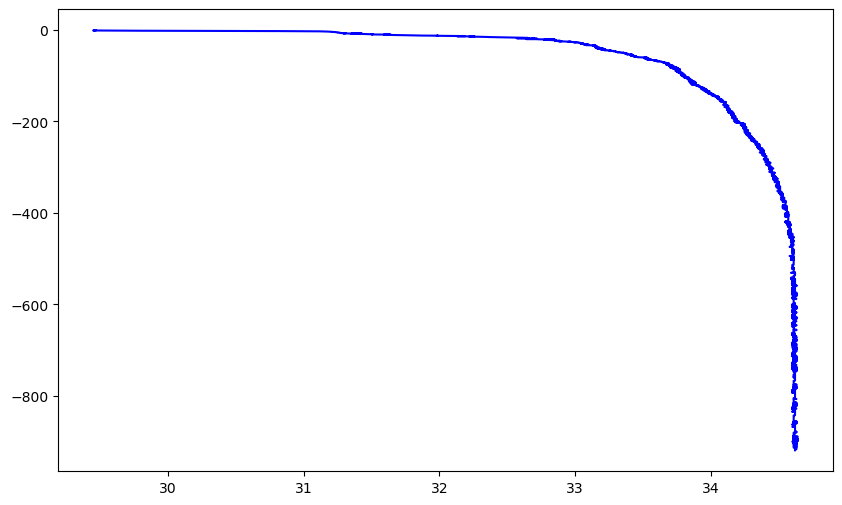

In [55]:
# plot salinity
plt.figure(figsize=(10, 6))
plt.plot(salinity, depth, label='Salinity', color='b')

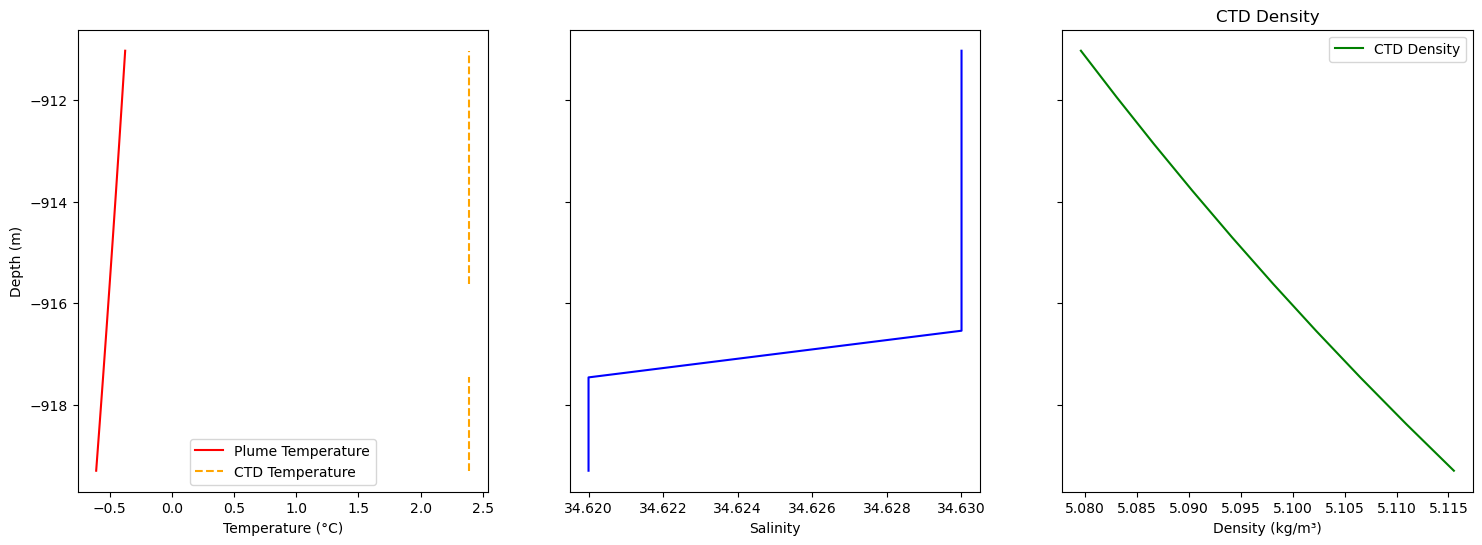

In [59]:
# create a plot of plume tempp, salinity and vertical velocity
fig, axs = plt.subplots(1, 3, figsize=(18, 6),  sharey=True)
axs[0].plot(result['T'], result['z'], label='Plume Temperature', color='r')
axs[0].plot(result['Ta'], result['z'], label='CTD Temperature', color='orange', linestyle='--')
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('Depth (m)')
axs[0].legend()
axs[1].plot(result['Sa'], result['z'], label='CTD Salinity', color='b')
axs[1].set_xlabel('Salinity')
axs[2].plot(result['u'], result['z'], label='CTD Density', color='g')
axs[2].set_xlabel('Density (kg/m³)')
axs[2].set_title('CTD Density')
axs[2].legend()

In [24]:
file_dir = r'G:\Other computers\My Laptop\ForGDRIVE\PLUME_work\PLUMES\OMG_L2_AXCTD_1-20250704_122741'
file_list = glob.glob(f'{file_dir}/*.nc')

# for each netcdf run the plume model and save the results to dictoonary
results = []
for file in tqdm(file_list, desc="Processing NetCDF files"):
    try:
        ds = xr.open_dataset(file)
        depth = ds['depth'].values * -1
        temperature = ds['temperature'].values
        salinity = ds['salinity'].values
        density = ds['density'].values

        valid_idx = ~np.isnan(depth) & ~np.isnan(temperature) & ~np.isnan(salinity) & ~np.isnan(density)
        depth = depth[valid_idx]
        temperature = temperature[valid_idx]
        salinity = salinity[valid_idx]
        density = density[valid_idx]

        if len(depth) < 10:
            logging.debug(f"Skipped file {file} due to insufficient data.")
            continue

        Q0, alpha, z_max = 5, 0.1, 1
        result = run_plume_profile(0, depth, temperature, salinity, density, Q0, alpha, z_max, Na=1)
        if result is not None:
            results.append(result)
    except Exception as e:
        logging.error(f"Error processing file {file}: {e}")


Processing NetCDF files:   0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\s1834371\AppData\Local\Temp\ipykernel_5552\2453064096.py:8: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file)
C:\Users\s1834371\AppData\Local\Temp\ipykernel_5552\2453064096.py:8: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default